# Jupiter-like Cloud Model and Reflection Spectrum 

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from exojax.utils.constants import kB, m_u
from exojax.atm.atmprof import pressure_layer_logspace

Parr, dParr, k = pressure_layer_logspace(log_pressure_top=-5., log_pressure_btm=2.0, nlayer=100)
alpha = 0.097
T0 = 200.
Tarr = T0 * (Parr)**alpha

mu = 2.0  # mean molecular weight
R = kB / (mu * m_u)
rho = Parr / (R * Tarr)

g=1.e5

In [3]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud

In [4]:
pdb_nh3 = PdbCloud("NH3")
pdb_nh3.load_miegrid()

amp_nh3 = AmpAmcloud(pdb_nh3,bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file exists: .database/particulates/virga/miegrid_lognorm_NH3.mg.npz
pdb.miegrid, pdb.rg_arr, pdb.sigmag_arr are now available. The Mie scattering computation is ready.


/home/kawahara/exojax/src/exojax/atm/atmphys.py:50: UserWarning: min temperature 65.4681396484375 K is smaller than min(vfactor t range) 179.10000610351562 K
  warnings.warn(


In [5]:
fsed = 3.
sigmag = 2.0
Kzz = 1.e5
VMR = 0.01
rg_layer, VMRc = amp_nh3.calc_ammodel(Parr, Tarr, mu, g, fsed=fsed, sigmag=sigmag, Kzz=Kzz, VMR=VMR)

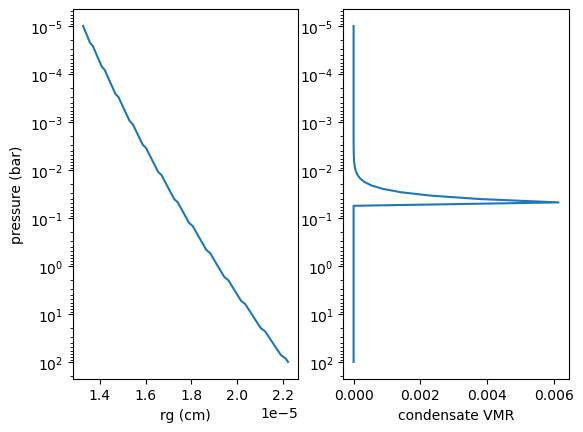

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(121)
plt.plot(rg_layer,Parr)
plt.xlabel("rg (cm)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(122)
plt.plot(VMRc,Parr)
plt.xlabel("condensate VMR")
plt.yscale("log")
ax.invert_yaxis()

In [7]:
sigmag = 2.0
sigmag_layer = jnp.ones_like(rg_layer)*sigmag

miepar = pdb_nh3.mie_parameters(rg_layer,sigmag_layer)

In [8]:
jnp.shape(miepar), jnp.shape(pdb_nh3.refraction_index_wavenumber)

((100, 196, 7), (196,))

/home/kawahara/anaconda3/lib/python3.10/site-packages/jax-0.4.12-py3.10.egg/jax/_src/array.py:361: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


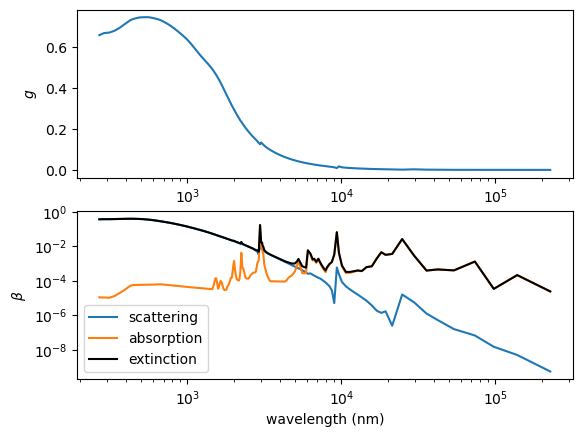

In [9]:
#plt.plot(pdb_nh3.refraction_index_wavenumber, miepar[50,:,0])
fig = plt.figure()
ax = fig.add_subplot(211)
plt.plot(pdb_nh3.refraction_index_wavelength_nm, miepar[50,:,3])  #Bext, Bsca, Babs, G, Bpr, Bback, Bratio
plt.xscale("log")
plt.xlabel("wavelenght (nm)")
plt.ylabel("$g$")
ax = fig.add_subplot(212)
plt.plot(pdb_nh3.refraction_index_wavelength_nm, miepar[50,:,1],label="scattering") 
plt.plot(pdb_nh3.refraction_index_wavelength_nm, miepar[50,:,2],label="absorption")  #Bext, Bsca, Babs, G, Bpr, Bback, Bratio
plt.plot(pdb_nh3.refraction_index_wavelength_nm, miepar[50,:,0],label="extinction",color="black") 
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavelength (nm)")
plt.ylabel("$\\beta$")
plt.savefig("miefig.png")